# Welcome to Augmentoolkit

This notebook is where you generate all your data.

Augmentoolkit is meant to allow instruct-tuned models to learn from books, even using themselves to generate new data through a sort-of bootstrapping method. It is meant to stop model creators from having to work as data annotators, and not actual model trainers. It is meant to allow anyone to make their own high-quality dataset with thousands of entries using cheap Open-Source APIs.

## Quickstart:

- Get this notebook and the other repo code onto a machine with an internet connection
- Paste your API key, favorite model name, and the endpoint URL of your preferred AI service, into the relevant constants located in the first code cell. Recommendation: [Together.ai with Hermes Mixtral works really nicely](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO).
- Run all the cells below and watch as the notebook generates questions, answers, and conversations based on Principles of Chemistry and Simple Sabotage.

If you want to add your own texts, follow the instructions in list item #1 above.

### Note: this notebook makes roughly 1/3 characters generated to be **mildly NSFW** by default. You will need to modify the character personality code in `./generation_functions/special_instructions.py` or use "Assistant mode" if you want something cleaner.

## Customization:
### Here are some ways you can adapt this notebook to your use case, along with a brief description of how to do so, arranged in increasing order of difficulty (this information is also available in the README):
1. ***Change the source texts used to generate training data.*** You can do this in the cell right below this one. **IMPORTANT** the filenames of these should be formatted in a specific way, since the filenames are used as part of the prompts and in at least one regex. You need to have them be like: `[textname], by authorname`. You can also include the publication date after the author name if you want, but note that this will tend to bias most of the characters to live in the era of the textbook, which may or may not be what you want.

2. ***Change the personalities of the characters generated.*** Currently, when generating characters for the multiturn conversation step, three randomly-selected traits are appended to the "special instructions" set of the prompt to constrain what kind of character is generated by the model. Depending on what kind of model you want to make, or even just if your preferences vary, then you will probably want to modify this a bit. You can do so in `./generation_functions/special_instructions.py`. A more in-depth description of the trait-axis system that I (over)thought up is available in the comments of that file.

3. ***Change the constants.*** There are a few constant values in this notebook, and in `./generation_functions/constant_values.py`. These constants are tested, but if your use case requires special settings (e.g., you want to make conversations from more permutations of existing questions; or you think the character counts for the "duplicate question/answer" validation functions are too restrictive) then feel free to change the related setting. The most intuitive and least-likely-to-break-anything settings to change are rearrangements_to_take and double_check_counter. Beyond that... you'll need to figure out what the function does before changing it if you expect it to run.

4. ***Assistant Mode*** Technically this could be considered part of 3), but it's different enough that I feel it warrants separate explanation. By default, the notebook is configured to produce RP-style data; "Assistant mode" is something you can toggle in the settings cell immediately below this one, which skips character and scenario generation and answers every question in a chat between a user and a helpful AI assistant (with no personality). This can be handled by smaller models, so if your budget or time are very limited, or you are using this for a more professional use case, feel free to turn this on.

5. ***Change the model.*** This is as simple as switching the LOGICAL_MODEL value out for another one, but your mileage may vary significantly. My personal recommendation is to use [Hermes Mixtral DPO](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO) for both models. You need at least 12k context on your model, and APIs typically don't allow RoPE scaling, so you're probably limited to MistralAI models here (or, heavens forbid, OpenAI. But GPT-4.5 + Augmentoolkit will BANKRUPT you fast, so be wary).

6. ***Change the examples.*** If you change the examples you can completely overhaul what this notebook does, but this requires a lot of prompting skill and possibly huge amounts of time to get it working again (source: most of my last three months were spent prompting, and most of this prompting was spent on the examples). Unless you want to convert this notebook from question-and-answer generation to some completely other task, I'd recommend changing only the conversation generation prompts -- they're a bit less finnicky, and if you just want to change the kind of characters generated (maybe you want a different writing style) that's where you'd find the differences.



## NOTE
You will want to turn off USE_SUBSET if you are doing a proper run over an entire text. It's on by default so you can iterate faster in the preparatory stages of dataset generation (and so that you can see the magic happen faster when you first use Augmentoolkit :) )

In [47]:
# NOTE NOTEBOOK SETTINGS AND CONSTANTS (some script file constants are in generation_functions/constants.py)

# Put your desired quant of your desired model in the relevant directories

import logging

# "airoboros-l2-70b-3.1.2.Q4_K_M.gguf" <- recommended for the large logical model
# "flatorcamaid-13b-v0.2.Q8_0.gguf" <- recommended for the normal logical model
# A6000s on Vast.ai are a good choice for running this notebook

LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/FlatOrcamaid-13B-v0.2-GPTQ"  # model used for decision-making and base question generation (should be "smart")

LARGE_LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/Airoboros-L2-70B-3.1.2-GPTQ"

ASSISTANT_MODE = False  # change to true if you want all conversations to be with an "AI language model" and not characters. Useful for more professional use cases.

DOUBLE_CHECK_COUNTER = 3  # Set to 1 to check outputs only once; set to 2 to check twice; set to 3 to check thrice, etc. Set to 0 to break everything in vet_question_loop() and elsewhere. Set to -1 and cause the universe to implode?

USE_SUBSET = True # Set to True if you want to use only a small subset of the text, to test whether it plays nicely with the current setup of the notebook

REARRANGEMENTS_TO_TAKE = 3  # How many of the possible permutations of tuples in a group to take and make multiturn convs out of. Adjust higher to get more data out of less text, but it might be a bit repetitive. NOTE your eval loss will be basically worthless if you aren't careful with how you shuffle your dataset when you're about to train.

USE_FILENAMES = False # Turn on if you want the model to use the names of your files as additional context (this is what original Augmentoolkit does). Useful if you have a small number of large input files grouped by subject matter, IE books. Turn off if you have a large number of files with meaningless names.

CONCURRENCY_LIMIT = 90  # Adjust this number based on the rate limit constraints of your api

API_KEY = "9167262f074477d041d8d6dfd8bb1ae47013369ee2c0127190acf4116539d8f6"

BASE_URL = "https://api.together.xyz" # Augmentoolkit-API should also be compatible with any other API provider that accepts OAI-style requests

COMPLETION_MODE=False

LOG_LEVEL = logging.INFO

source_texts = [ # add your texts here
    "./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt",
]

## Below: Defines and imports functions that you will probably use no matter what cells in the notebook you choose to run:

In [48]:
import os
import uuid

# This is in no way best practices, but all my prompts being searchable and separate files is a good way to make my life easier.
import pkgutil
import importlib
import sys
from tqdm import asyncio as tqdmasyncio
import asyncio

# Set up rate-limit-conscious functions
semaphore = asyncio.Semaphore(CONCURRENCY_LIMIT)

async def run_task_with_limit(task):
    async with semaphore:
        # Run your task here
        return await task


# We have to define this up here so that two-step generation works, you'll see later.
multi_turn_convs_info_dir = "./multi_turn_convs_info"  # we generate all the information fed to the multiturn prompt, and generate the actual multiturn prompt, separately; since every step but the last is capable of being done by a 13b

sys.path.append("./generation_functions")
sys.path.append("./control_flow_functions")

import augmentoolkit.generation_functions as generation_functions  # This is the package directory
from augmentoolkit.control_flow_functions import control_flow_functions

# First, import all modules so they can be reloaded
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    importlib.import_module(module_name)

# Now, reload each module and import all callable attributes
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    # Reload the module
    module = importlib.reload(sys.modules[module_name])
    # Iterate through each attribute in the reloaded module
    for attribute_name in dir(module):
        # Retrieve the attribute
        attribute = getattr(module, attribute_name)
        if callable(attribute):
            # If it's callable, it's a function or class, so you set it in the globals dictionary
            globals()[attribute_name] = attribute

In [49]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [50]:
from transformers import AutoTokenizer
import re
from tqdm import tqdm
import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

tokenizer = AutoTokenizer.from_pretrained(
    "Gryphe/MythoMax-L2-13b"
)  # It doesn't matter what model goes here, really

sentence_chunks = []
for source_text in source_texts:
    sentence_chunks += control_flow_functions.sentence_chunking_algorithm(source_text, tokenizer)

conversions = [("\n", " "), ("  ", " ")]

paragraphs_processed = [
    (control_flow_functions.fix_text(conversions, seq[0]), seq[1]) for seq in sentence_chunks
]

[nltk_data] Downloading package punkt to /Users/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Processing ./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt: 100%|██████████| 603/603 [00:00<00:00, 11447.14it/s]


#### Inspect various features of the text you have fed in to see if it came out alright-ish

In [51]:
len(paragraphs_processed)

52

In [52]:
paragraphs_processed[0]

('\ufeffThe Project Gutenberg eBook of Simple Sabotage Field Manual   This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Simple Sabotage Field Manual  Author: United States. Office of Strategic Services Release date: August 4, 2008 [eBook #26184]         Most recently updated: February 28, 2022 Language: English    [Illustration]   Simple Sabotage Field Manual Office of Strategic Services   OSS REPRODUCTION BRANCH SIMPLE SABOTAGE FIELD MANUAL Strategic Services (Provisional) STRATEGIC SERVICES FIELD MANUAL No. 3   Office of Strategic Services Washington, D. C. 17 January 1944  This Simple Sabot

In [53]:
print(paragraphs_processed[:3])

[('\ufeffThe Project Gutenberg eBook of Simple Sabotage Field Manual   This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Simple Sabotage Field Manual  Author: United States. Office of Strategic Services Release date: August 4, 2008 [eBook #26184]         Most recently updated: February 28, 2022 Language: English    [Illustration]   Simple Sabotage Field Manual Office of Strategic Services   OSS REPRODUCTION BRANCH SIMPLE SABOTAGE FIELD MANUAL Strategic Services (Provisional) STRATEGIC SERVICES FIELD MANUAL No. 3   Office of Strategic Services Washington, D. C. 17 January 1944  This Simple Sabo

In [54]:
import json
import os
from tqdm import tqdm
import asyncio

# Create directory if it doesn't exist
output_dir = "./worthy_for_questions"
os.makedirs(output_dir, exist_ok=True)

# Determine which paragraphs are worthy of making questions from
judged_worthy_for_questions = []

await control_flow_functions.filter_all_questions(paragraphs_processed, judged_worthy_for_questions, engine_wrapper, output_dir, take_subset=USE_SUBSET, use_filenames=False, rtwl=run_task_with_limit, completion_mode=COMPLETION_MODE,logging_level=LOG_LEVEL)

100%|██████████| 13/13 [00:00<00:00, 3407.45it/s]

LOADING:  failed|./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944
LOADING:  failed|./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944
LOADING:  {'paragraph': 'It also can be conveyed directly: statements praising the effectiveness of simple sabotage can be contrived which will be published by white radio, freedom stations, and the subversive press. Estimates of the proportion of the population engaged in sabotage can be disseminated. Instances of successful sabotage already are being broadcast by white radio and freedom stations, and this should be continued and expanded where compatible with security. (c) More important than (a) or (b) would be to create a situation in which the citizen-saboteur acquires a sense of responsibility and begins to educate others in simple sabotage. (2) _Encouraging Destructiveness_ It should be pointed out to the saboteur where the circumstances are suitable, that he is acting in self-d

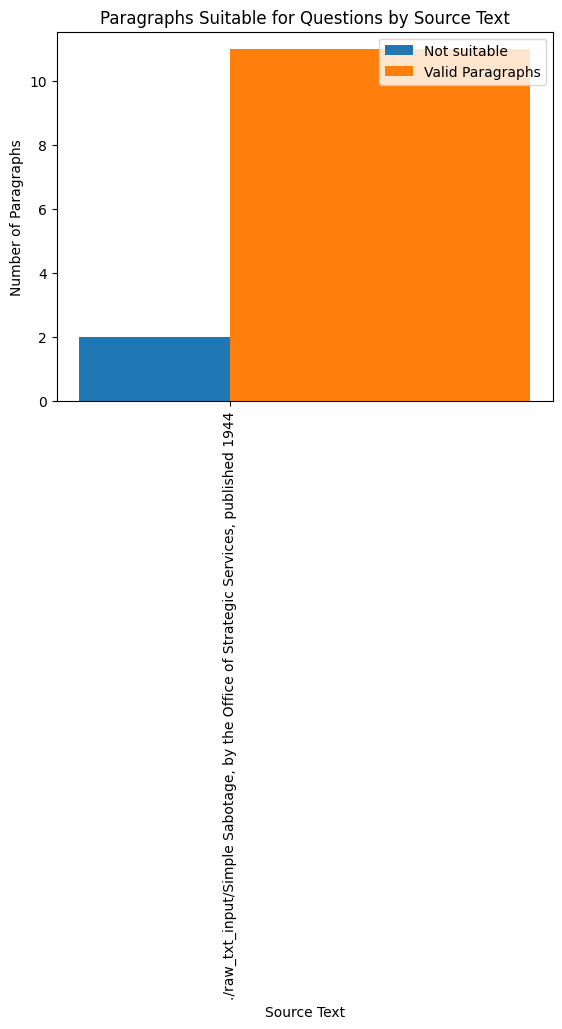

In [55]:
filtered_worthy_for_questions = control_flow_functions.filter_and_graph(judged_worthy_for_questions)

In [56]:
print(filtered_worthy_for_questions[0])

('It also can be conveyed directly: statements praising the effectiveness of simple sabotage can be contrived which will be published by white radio, freedom stations, and the subversive press. Estimates of the proportion of the population engaged in sabotage can be disseminated. Instances of successful sabotage already are being broadcast by white radio and freedom stations, and this should be continued and expanded where compatible with security. (c) More important than (a) or (b) would be to create a situation in which the citizen-saboteur acquires a sense of responsibility and begins to educate others in simple sabotage. (2) _Encouraging Destructiveness_ It should be pointed out to the saboteur where the circumstances are suitable, that he is acting in self-defense against the enemy, or retaliating against the enemy for other acts of destruction. A reasonable amount of humor in the presentation of suggestions for simple sabotage will relax tensions of fear. (a) The saboteur may hav

### The cell below begins generating questions. SOME OF THESE MAY FAIL and have to retry due to model errors (the API branch cannot use grammars). But if you let it run you will see that the vast majority eventually get through.

In short, don't get scared by tracebacks.

In [57]:
# control flow
import json
import os
import glob

# Directory for QA tuples
qa_tuples_dir = "./qatuples_raw"
if not os.path.exists(qa_tuples_dir):
    os.makedirs(qa_tuples_dir)

# Initialize vetted_qa_tuples
vetted_qa_tuples = []  # tuple list of qa tuples that have been judged good

# Attempt to initialize filtered_worthy_for_questions
try:
    _ = filtered_worthy_for_questions
except NameError:
    filtered_worthy_for_questions = []

if not filtered_worthy_for_questions:
    # Load all files in the qa_tuples_dir if filtered_worthy_for_questions is not initialized
    existing_files = glob.glob(os.path.join(qa_tuples_dir, "*.json"))
    for file_path in existing_files:
        with open(file_path, "r") as file:
            qa_tuple = tuple(json.load(file))
            print(f"Loaded {file}")
        vetted_qa_tuples.append(qa_tuple)
else:
    tasks = [control_flow_functions.generate_qatuples_from_para(
        idx,
        para,
        engine_wrapper=engine_wrapper,
        vetted_qa_tuples=vetted_qa_tuples,
        qa_tuples_dir=qa_tuples_dir,
        double_check_counter=DOUBLE_CHECK_COUNTER,
        use_filenames=USE_FILENAMES,
        completion_mode=COMPLETION_MODE,
        logging_level=LOG_LEVEL) for idx,para in enumerate(filtered_worthy_for_questions)]
    limited_tasks_qgen = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qgen):
            await future
    

  0%|          | 0/11 [00:00<?, ?it/s]2024-02-09 01:59:16,807 - INFO - Formatted prompt for generation: [
  {
    "role": "system",
    "content": "As an educational AI specializing in question generation, your task is to plan out high-quality, critical thinking questions strictly based on provided paragraphs. Focus on understanding, application, analysis, and synthesis of the text's ideas. Develop a comprehensive plan to generate questions that test comprehension and memorization of explicit content in the paragraphs. Aim for longer, challenging questions that can be answered with the given information.\n\nEnsure your questions strictly adhere to the text's content, avoiding any external topics. The key step is to analyze the text thoroughly and brainstorm potential questions based on this analysis. Do not list final questions in this step.\n\nYour response should be concise, focusing solely on the text's content to test knowledge without the text's reference. Maintain a step-by-step 




OUTER LOOP CALL GENERATE QPLAN para: ('It also can be conveyed directly: statements praising the effectiveness of simple sabotage can be contrived which will be published by white radio, freedom stations, and the subversive press. Estimates of the proportion of the population engaged in sabotage can be disseminated. Instances of successful sabotage already are being broadcast by white radio and freedom stations, and this should be continued and expanded where compatible with security. (c) More important than (a) or (b) would be to create a situation in which the citizen-saboteur acquires a sense of responsibility and begins to educate others in simple sabotage. (2) _Encouraging Destructiveness_ It should be pointed out to the saboteur where the circumstances are suitable, that he is acting in self-defense against the enemy, or retaliating against the enemy for other acts of destruction. A reasonable amount of humor in the presentation of suggestions for simple sabotage will relax te

2024-02-09 01:59:24,282 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:24,284 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!
  9%|▉      

Q ERROR: Generation step failed -- too many retries!
Q ERROR: Generation step failed -- too many retries!


2024-02-09 01:59:24,809 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:24,811 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!
 27%|██▋    

Q ERROR: Generation step failed -- too many retries!
Q ERROR: Generation step failed -- too many retries!
Q ERROR: Generation step failed -- too many retries!


2024-02-09 01:59:25,063 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:25,065 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!


Q ERROR: Generation step failed -- too many retries!


2024-02-09 01:59:25,455 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:25,457 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!
 64%|██████▎

Q ERROR: Generation step failed -- too many retries!
Q ERROR: Generation step failed -- too many retries!


2024-02-09 01:59:25,995 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:25,997 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!
 82%|███████

Q ERROR: Generation step failed -- too many retries!


2024-02-09 01:59:27,547 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 01:59:27,549 - ERROR - Error in Generation Step: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 97, in generate
    return ret, prompt_formatted + [{"role": "assistant", "content": filtered_response}]
TypeError: can only concatenate str (not "list") to str
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py", line 973, in generate_qatuples_from_para
    ) = await qatuples_planner.generate(
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 103, in generate
    raise Exception("Generation step failed -- too many retries!")
Exception: Generation step failed -- too many retries!
 91%|███████

Q ERROR: Generation step failed -- too many retries!
Q ERROR: Generation step failed -- too many retries!


In [58]:
print(
    "-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):"
)
nones = list(filter(lambda x: x[0] is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa[0] is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):
Nones: 0
Non-nones: 0
Total: 0
---------------- ONTO EXAMPLES GENERATION-------------------


In [59]:
# Check for and fix the common mistake: mentioning "the text".
writepath = "./qatuples_revised"
import json

# Assuming vetted_qa_tuples is a list that might or might not exist
try:
    _ = vetted_qa_tuples
except NameError:
    vetted_qa_tuples = []

# Load all files at the start if vetted_qa_tuples is empty
if not vetted_qa_tuples:
    # Check if the directory exists
    if os.path.exists(writepath):
        # List all files in directory
        for file_name in os.listdir(writepath):
            file_path = os.path.join(writepath, file_name)
            try: # for each file already generated, see if it succeeded or failed; if it succeeded, append its contents; if it failed, append None for stats logging
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    print(f"Loading file: {file_path}")
                    if content == "failed":
                        vetted_qa_tuples.append(None)
                    else:
                        try:
                            data = json.loads(content)
                            vetted_qa_tuples.append(
                                (data[0], data[1], data[2], data[3])
                            )
                        except json.JSONDecodeError:
                            print("JSON decode error with the contents:", content)
                            vetted_qa_tuples.append(None)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

else:
    old_tuples = vetted_qa_tuples.copy()
    tasks = [control_flow_functions.repair_qatuple_context(idx, tup, engine_wrapper, writepath, vetted_qa_tuples,use_filenames=USE_FILENAMES) for idx, tup in enumerate(vetted_qa_tuples)]
    limited_tasks_qcorrection = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qcorrection): 
        await future

In [60]:
# Print stats related to revised qatuples, and filter out nones (questions that were unanswerable due to lack of context).
import json
import os

print("-------------- QUESTIONS REVISED ------------- STATS SO FAR:")
nones = list(filter(lambda x: x is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS REVISED ------------- STATS SO FAR:
Nones: 0
Non-nones: 0
Total: 0
---------------- ONTO EXAMPLES GENERATION-------------------


In [61]:
qa_tuples_by_paragraph = control_flow_functions.group_by_text(vetted_qa_tuples)

In [62]:
import os

if not os.path.exists(multi_turn_convs_info_dir):
    os.makedirs(multi_turn_convs_info_dir)

In [63]:
import json
import random
import itertools

multi_turn_convs_info = []


tasks = [control_flow_functions.create_info(idx,group,engine_wrapper, ASSISTANT_MODE, multi_turn_convs_info,multi_turn_convs_info_dir, rearrangements_to_take=REARRANGEMENTS_TO_TAKE,use_filenames=USE_FILENAMES, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,group in enumerate(qa_tuples_by_paragraph)]
limited_tasks_infocreation = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_infocreation):
    await future

0it [00:00, ?it/s]


### No notebook restart needed for the API notebook!

### BUT You still might've separated your generations into large and small models, so we reinitialize the engine wrapper

In [64]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LARGE_LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [65]:
import os
import json

convs_info = control_flow_functions.read_json_files_info(multi_turn_convs_info_dir)

In [66]:
import os
import json
import random
import itertools
import asyncio

multi_turn_convs_dir = "./multi_turn_convs"
if not os.path.exists(multi_turn_convs_dir):
    os.makedirs(multi_turn_convs_dir)

multi_turn_convs = []

tasks = [control_flow_functions.create_conversation(idx,info, engine_wrapper, multi_turn_convs, multi_turn_convs_dir, assistant_mode=ASSISTANT_MODE, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,info in enumerate(convs_info)]
limited_tasks_convwriting = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_convwriting):
    await future

0it [00:00, ?it/s]


# Yay! Now you have a dataset!
### GPT wrote the cell below. I think it successfully converts things to ShareGPT format for use with axolotl, but I am not sure because I don't know that format very well and haven't used Axolotl. However, the json produced by the second function looks fine.

In [67]:
import os
import json

# Make ShareGPT-format dataset (I think, still need verification it actually works)
control_flow_functions.convert_directory_to_list("./multi_turn_convs/")
# Make dataset in a format that has all the information. See README for details on this format.
control_flow_functions.convert_directory_and_process_conversations("./multi_turn_convs/")

Conversion complete. Master list written to 'master_list.json'. Simplified data written to 'simplified_data.json'.
Conversion complete. The processed master list is written to 'processed_master_list.json'.


In [68]:
with open("./processed_master_list.json") as f:
    first = f.read()
    data = json.loads(first)

In [69]:
# For curiosity's sake, you can find out how many lines of dialogue you generated
def filter_and_flatten(lst):
    # Initialize an empty list to hold the flattened elements
    flat_list = []

    # Loop through each sublist in the main list
    for sublst in lst:
        # Check if the first element of the sublist is itself a list (subsublist1)
        if isinstance(sublst[0], list):
            # Extend the flat_list with the elements from subsublist1
            flat_list.extend(sublst[0])

    return flat_list


len(filter_and_flatten(data))

0